# Exploratory Data Analysis (EDA):

This dataset provides a list of lyrics from 1950 to 2019 describing music metadata as sadness, danceability, loudness, acousticness, etc. Authors also provide some information as lyrics which can be used to do natural language processing.

Moura, Luan; Fontelles, Emanuel; Sampaio, Vinicius; França, Mardônio (2020), “Music Dataset: Lyrics and Metadata from 1950 to 2019”, Mendeley Data, V3, doi: 10.17632/3t9vbwxgr5.3

https://www.kaggle.com/datasets/saurabhshahane/music-dataset-1950-to-2019/data

## Musical Data Understanding and Genre Predictions (1950-2019):


Shape of Data: (28372, 31)
Missing values:
genre           0
danceability    0
energy          0
valence         0
dtype: int64
Model Accuracy: 0.41
Classification Report:
              precision    recall  f1-score   support

       blues       0.35      0.30      0.32       921
     country       0.42      0.54      0.47      1089
     hip hop       0.55      0.43      0.48       181
        jazz       0.48      0.37      0.42       769
         pop       0.37      0.43      0.40      1408
      reggae       0.48      0.47      0.48       500
        rock       0.44      0.33      0.37       807

    accuracy                           0.41      5675
   macro avg       0.44      0.41      0.42      5675
weighted avg       0.42      0.41      0.41      5675



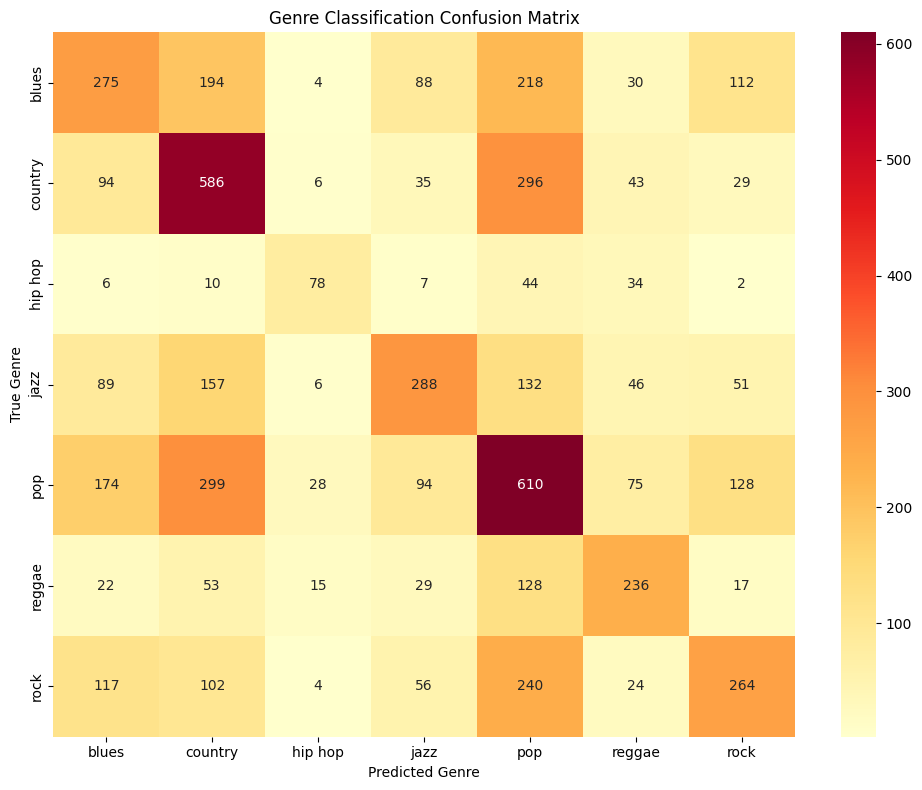

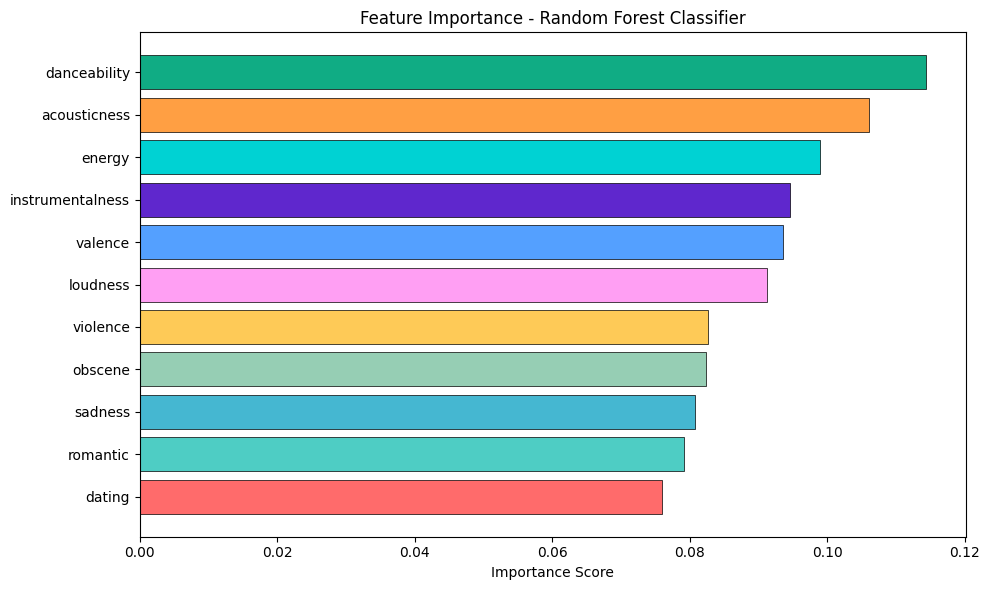

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# data loaded

df = pd.read_csv('tcc_ceds_music.csv')


print(f"Shape of Data: {df.shape}") # rows/columns

# missing values check 

print("Missing values:")
print(df[['genre', 'danceability', 'energy', 'valence']].isnull().sum()) # counting and summing up empty/missing areas

# genres for classification

major_genres = ['pop', 'rock', 'jazz', 'hip hop', 'country', 'reggae', 'blues']
df_2 = df[df['genre'].isin(major_genres)].copy() # new data frame to manipulate 

# features used to predict genre of a song

feature_columns = ['danceability', 'loudness', 'acousticness', 'instrumentalness', 
                  'valence', 'energy', 'dating', 'violence', 'romantic', 'obscene', 'sadness']

input = df_2[feature_columns] # storing features for input that the model can learn from 
output = df_2['genre'] # target labeling info that the model must predict 

# splitting the data for 80/20 train/test compilation

input_train, input_test, output_train, output_test = train_test_split(input, output, test_size=0.2, stratify=output)

# training model

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(input_train, output_train) # fit the random forest model to the training data so that it can learn patterns 

# predict genre

output_prediction = rf_model.predict(input_test) # begins predicting genre for input set of feature columns 

# accuracy score

accuracy = accuracy_score(output_test, output_prediction) # compares predictions for genre with what genre labels for each song actually were 
print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(output_test, output_prediction)) # showcasing performance metrics for each genre analyzed

"""
Precision: How many predicted as X were actually X (Reliability)
Recall: How many actual X were correctly predicted as X (Validity)
F1-Score: Balance between precision and recall
Support: Number of samples for each genre 
"""

# confusion matrix heatmap to display correct and incorrect predictions 

plt.figure(figsize=(10, 8))
heatmap_cm = confusion_matrix(output_test, output_prediction) # predictions on the diagonal are correct, but predictions off of the diagonal are incorrect errors
sns.heatmap(heatmap_cm, annot=True, fmt='d', cmap='YlOrRd', # display numbers as integers (no floating point values) with color scheming
            xticklabels=rf_model.classes_, 
            yticklabels=rf_model.classes_) # tick mark labeling corresponding to genres (classes)
plt.title('Genre Classification Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.tight_layout()
plt.show()

# horizontal bar chart to see how much importance each feature had in calculation

plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({ # creating dataframe for storage 
    'feature': feature_columns, # names for each feature 
    'importance': rf_model.feature_importances_ # ranking model's feature importance with scoring (sums up to be 1.0 in total) 
}).sort_values('importance', ascending=True)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', 
          '#FF9FF3', '#54A0FF', '#5F27CD', '#00D2D3', '#FF9F43', '#10AC84']

plt.barh(feature_importance['feature'], feature_importance['importance'], color = colors, linewidth = 0.5, edgecolor = 'black') # Y - X mapping for variables (horizontal)
plt.title('Feature Importance - Random Forest Classifier')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [31]:
# indices of the test set to link back to original data

test_indices = input_test.index  # original row indices from df_2

# results DataFrame (actual vs predicted)

detailed_results = pd.DataFrame({
    'actual_genre': output_test, # true genre labels 
    'predicted_genre': output_prediction, # model predictions 
    'is_correct': (output_test == output_prediction) # true if correct, false if wrong
}, index=test_indices)

# assign song detail columns for analysis (if available for each song)

available_columns = [col for col in ['artist_name', 'track_name', 'release_date', 'lyrics'] if col in df_2.columns]
print(f"Available song detail columns: {available_columns}")

if available_columns: # getting song details from dataset

    song_details = df_2[available_columns]
    
    # merging song details with model's genre prediction results
    
    detailed_results = detailed_results.merge(
        song_details, 
        left_index=True, # index from left DataFrame (detailed_results)
        right_index=True, # index from right DataFrame (song_details)
        suffixes=('', '_original') # suffix for overlapping column names 
    )
    
    # getting misclassified songs
    
    misclassified_songs = detailed_results[~detailed_results['is_correct']]
    
    print(f"\nTotal misclassified songs: {len(misclassified_songs)}")
    print(f"Misclassification rate: {len(misclassified_songs)/len(input_test):.2%}")
    
    # top misclassified songs
    
    print("\nTop 15 Misclassified Songs:")

    
    for song_number, (index, row) in enumerate(misclassified_songs.head(15).iterrows()):
        print(f"{song_number+1:2d}. ", end="")
        
        if 'artist_name' in row:
            artist = str(row['artist_name'])[:25]  # truncate to 25 characters
            print(f"Artist: {artist:<25}", end="") # new line with left-aligned padding to 25 width for each artist (proper spacing) 
        
        if 'track_name' in row:
            track = str(row['track_name'])[:35]  # truncate to 35 characters
            print(f"Track: {track:<35}", end="") # new line with left-aligned padding to 35 width for each track (better space)
        
      
        print(f"Actual: {row['actual_genre']:>8} --> Predicted: {row['predicted_genre']:>8}") # right-aligned padding to 8 width for better spacing in output
        
        # key 'audio' features that might explain the misclassification
        
        if index in input_test.index: # if index exists get the values/features of that song index and print them
            song_features = input_test.loc[index]
            print(f"     Features - Dance: {song_features['danceability']:.2f}, "
                  f"Energy: {song_features['energy']:.2f}, "
                  f"Acoustic: {song_features['acousticness']:.2f}, "
                  f"Valence: {song_features['valence']:.2f}")
        print("\n")
    
    # most common misclassification patterns (commonly confused with one another)
    
    print("\nMost Common Misclassification Patterns:")

    confusion_patterns = pd.crosstab(misclassified_songs['actual_genre'], 
                                   misclassified_songs['predicted_genre'])
    print(confusion_patterns) # cross tabulation frequency table (matrix) being produced to show number of songs actually apart of a certain genre being predicted as such 
    
    # actual vs predicted
    # genres most confused by model
    
    print("\nTop Genre Confusion Pairs:")
   
    confusion_pairs = [] # empty list to store the confused genre pairs 
    for actual_genre in confusion_patterns.index:
        for predicted_genre in confusion_patterns.columns:
            if actual_genre != predicted_genre: # for genres in nested loop, if actual genre doesn't equal predicted genre, assign the result to a count and append the outcome as a flawed pair
                count = confusion_patterns.loc[actual_genre, predicted_genre] # getting value at the intersection of predicted genre rows and actual genre columns to see how many were misclassified 
                confusion_pairs.append((actual_genre, predicted_genre, count))
    
    # sorting by frequency (count -- 3rd element of list) and showing top 5 confusion pairs in descending order
    
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    for number, (actual, predicted, count) in enumerate(confusion_pairs[:5]):
        print(f"{number+1}. {actual} --> {predicted}: {count} songs")
        
else: # if some details weren't present print that and showcase what is present in dataframe
    print("No song detail columns found in the dataset.")
    print("Available columns:", df_2.columns.tolist())

Available song detail columns: ['artist_name', 'track_name', 'release_date', 'lyrics']

Total misclassified songs: 3338
Misclassification rate: 58.82%

Top 15 Misclassified Songs:
 1. Artist: celtic woman             Track: scarborough fair                   Actual:      pop --> Predicted:     jazz
     Features - Dance: 0.20, Energy: 0.23, Acoustic: 0.92, Valence: 0.08


 2. Artist: tammy wynette            Track: help me make it through the night  Actual:  country --> Predicted:     jazz
     Features - Dance: 0.37, Energy: 0.20, Acoustic: 0.72, Valence: 0.37


 3. Artist: u2                       Track: god part ii                        Actual:     rock --> Predicted:      pop
     Features - Dance: 0.61, Energy: 0.77, Acoustic: 0.00, Valence: 0.81


 4. Artist: post malone              Track: blame it on me                     Actual:      pop --> Predicted:  country
     Features - Dance: 0.64, Energy: 0.59, Acoustic: 0.14, Valence: 0.30


 5. Artist: blake shelton            Tra